<a href="https://colab.research.google.com/github/chitrangada-juneja/Analysis-of-Crime-in-Tucson/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# necessary imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import geopy
from geopy.distance import geodesic
from sklearn.metrics import mean_squared_error
import itertools

from sklearn.model_selection import train_test_split



ModuleNotFoundError: No module named 'numpy'

# Exploration


First, we will create dataframes from Tucson Police Reported Crimes data and Neighborhood Income data.

In [ ]:
# Assumes crime dataset https://gisdata.tucsonaz.gov/datasets/tucson-police-reported-crimes/explore already in My Drive/datasets as crimes.csv
crimes_df = pd.read_csv('datasets/crimes.csv')
crimes_df.head()

Mounted at /content/drive


,IncidentID,DateOccurred,Year,Month,Day,TimeOccur,Division,Ward,UCR,UCRDescription,Offense,OffenseDescription,CallSource,ESRI_OID
0,1800330010,2018/03/30 00:00:00+00,2018,March,Fri,2054,Midtown,6.0,5,05 - BURGLARY,501,Burglary - Force,NaN,1
1,807190154,2018/06/15 00:00:00+00,2018,June,Fri,0243,South,1.0,1,01 - HOMICIDE,101,Criminal Homicide - Murder,NaN,2
2,1801010138,2018/01/01 00:00:00+00,2018,January,Mon,0412,Midtown,3.0,3,03 - ROBBERY,304,Robbery - Convenience Stores,Call For Service,3
3,1801010111,2018/01/01 00:00:00+00,2018,January,Mon,0324,South,1.0,4,"04 - ASSAULT, AGGRAVATED",413,Aggravated Assault - Domestic Violence (DV),Call For Service,4
4,1801010244,2018/01/01 00:00:00+00,2018,January,Mon,0950,South,5.0,6,06 - LARCENY,610,Larceny - All Other,Call For Service,5


In [ ]:
# Assumes income dataset https://gisdata.tucsonaz.gov/datasets/cotgis::neighborhood-income/explore?location=32.197487%2C-110.889177%2C9.46&showTable=true as income.csv
income_df = pd.read_csv('datasets/income.csv')

# drop rows with no data
income_df = income_df[income_df['HasData_1'] != 0]
income_df.head()

,OBJECTID,NAME,WARD,DATASOURCE,ID,sourceCountry,ENRICH_FID,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,...,AGGDIA75CY,ID_1,sourceCountry_1,ENRICH_FID_1,aggregationMethod_1,populationToPolygonSizeRating_1,apportionmentConfidence_1,HasData_1,TOTHH_CY,WLTHINDXCY
0,1,A Mountain,1,NEIGHBORHOODS,0,US,1,BlockApportionment:US.BlockGroups,2.191,2.576,...,1590160,0,US,1,BlockApportionment:US.BlockGroups,2.191,2.576,1,1103,32
1,2,Adelanto,3,NEIGHBORHOODS,1,US,2,BlockApportionment:US.BlockGroups,2.191,2.576,...,154598,1,US,2,BlockApportionment:US.BlockGroups,2.191,2.576,1,117,28
2,3,Alvernon Heights,5,NEIGHBORHOODS,2,US,3,BlockApportionment:US.BlockGroups,2.191,2.576,...,172634,2,US,3,BlockApportionment:US.BlockGroups,2.191,2.576,1,99,26
3,4,Amphi,3,NEIGHBORHOODS,3,US,4,BlockApportionment:US.BlockGroups,2.191,2.576,...,2760918,3,US,4,BlockApportionment:US.BlockGroups,2.191,2.576,1,3105,20
4,5,Armory Park,6,NEIGHBORHOODS,4,US,5,BlockApportionment:US.BlockGroups,2.191,2.576,...,3785750,4,US,5,BlockApportionment:US.BlockGroups,2.191,2.576,1,1223,48


We will explore the number of crimes by ward using a bar plot, starting to think about the relationship between location and crime.

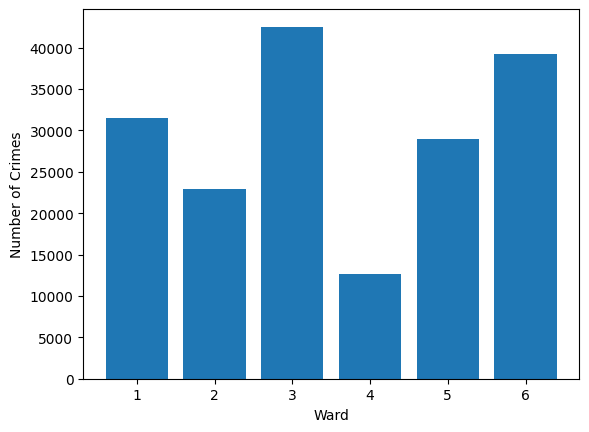

In [ ]:
# generate a bar plot for crime data vs ward number
plt.bar(crimes_df['Ward'].value_counts().index, crimes_df['Ward'].value_counts())
plt.rcParams['figure.figsize'] = [3, 3]

plt.xlabel('Ward')
plt.ylabel('Number of Crimes')

plt.show()

# Clean data for police incidents

Since the crime dataframe gave limited amounts of data about each crime, we sought out new data, and found datasets for police incidents, which contains a column for the neighborhood in which the incident occurred. Now we will clean data about neighborhood populations.

In [ ]:
# Assumes population dataset https://gisdata.tucsonaz.gov/datasets/a4ed8b6bf0ad4515bfc43df83175e40f_0/explore?location=32.197880%2C-110.889177%2C10.33&showTable=true as populations.csv
pop_df = pd.read_csv('datasets/populations.csv')

# drop rows with no data
pop_df = pop_df[pop_df['HasData'] != 0]

We will now clean data about police incidents, using separate datasets from years 2014 through 2023. We will create one large dataframe with all the incidents in order to have a larger dataset to better see relationships.  

In [ ]:
# read police incident data for all years
years = [2014, 2015, 2016, 2018, 2019, 2020, 2021, 2022, 2023]
dfs = []
crime_rate_data = []
crime_rate_df = pd.DataFrame(columns=['NAME', '2014', '2015', '2016', '2018', '2019', 'AVG_CRIME_RATE'])

for year in years:
  fp = 'datasets/incidents_' + str(year) + '.csv'
  year_df = pd.read_csv(fp, low_memory=False)

  # drop rows where latitude/longitude is 0
  year_df = year_df[year_df['LAT'] != 0]
  year_df = year_df[year_df['LONG'] != 0]

  # drop rows where latitude/longitude not in tucson
  min_lat = 31.5
  max_lat = 32.5
  min_long = -111.3
  max_long = -110.5
  year_df = year_df[(year_df['LAT'] >= min_lat) & (year_df['LAT'] <= max_lat) & (year_df['LONG'] >= min_long) & (year_df['LONG'] <= max_long)]

  # get yearly populations
  if year == 2014:
    pop_col = 'TSPOP14_CY'
  elif year == 2015:
    pop_col = 'TSPOP15_CY'
  elif year == 2016:
    pop_col = 'TSPOP16_CY'
  elif year == 2018:
    pop_col = 'TSPOP18_CY'
  elif year  == 2019:
    pop_col = 'TOTPOP_CY'

  if year < 2020 and year != 2017 and pop_col in pop_df.columns:

    # iterate through neighborhoods
    for n_name in year_df['NHA_NAME'].unique():

      # ignore nan neighborhoods
      if pd.isna(n_name):
        continue

      # add neighborhood to crime_rate_df if not already there
      if n_name not in crime_rate_df['NAME'].values:
        crime_rate_data.append({'NAME': n_name})

      # get number of incidents in neighborhood
      num_incidents = len(year_df[year_df['NHA_NAME'] == n_name])

      # Get population of neighborhood
      filtered_pop = pop_df[pop_df['NAME'] == n_name]
      if not filtered_pop.empty and pop_col in filtered_pop.columns:
          yr_population = filtered_pop[pop_col].iloc[0]
          crime_rate_yr = num_incidents / yr_population
      else:
          # set crime rate to na
          crime_rate_yr = np.nan

      # add crime rate to crime_rate_df in the year column
      for entry in crime_rate_data:
        if entry['NAME'] == n_name:
          entry[str(year)] = crime_rate_yr

  # drop unneeded columns to make the data easier to read
  cols = ['INCI_ID', 'OFFENSE', 'WARD', 'NHA_NAME','LAT', 'LONG', 'Crime', 'CrimeType', 'CrimeCategory']
  year_df = year_df[list(cols)]

  dfs.append(year_df)


# create crime_rate dataframe
crime_rate_df = pd.DataFrame(crime_rate_data)

# Calculate mean crime rate for years 2014 to 2019
valid_years = ['2014', '2015', '2016', '2018', '2019']
crime_rate_df['AVG_CRIME_RATE'] = crime_rate_df[valid_years].mean(axis=1, skipna=True)

# combine all years into one dataframe
df = pd.concat(dfs, ignore_index=True)


# Clean data for neighborhoods

We will now create a dataframe with relevant info about each neighborhood. Each row will represent a neighborhood, and columns will have data about population, crimes and crime rates, and eventually population demographics and location. As part of the preprocessing, we will create a small dataframe that is useful in calculating average crime rates by using crime count and population values from relevant years. This intermediate step is used to add the crime rate column to the neighborhoods dataframe.

In [ ]:
# create a dataframe with only neighborhood names and populations from 2019 data
neighborhoods_df = pop_df[['NAME', 'TOTPOP_CY']]

# drop rows with total population = 0
neighborhoods_df = neighborhoods_df[neighborhoods_df['TOTPOP_CY'] != 0]

# rename columns
neighborhoods_df = neighborhoods_df.rename(columns={'TOTPOP_CY': '2019_POP'})

# drop rows with no neighborhood data from crime df
crime_df = df[pd.notna(df['NHA_NAME'])]

# drop row with no data from crime_rate_df
crime_rate_df = crime_rate_df[pd.notna(crime_rate_df['NAME'])]

# add total crime counts
neighborhoods_df = neighborhoods_df.copy()
for index, row in neighborhoods_df.iterrows():
    neighborhood_name = row['NAME']
    crime_count = len(crime_df[crime_df['NHA_NAME'] == neighborhood_name])
    neighborhoods_df.at[index, 'CRIMES'] = crime_count

# add crime rate from crime_rate_df
neighborhoods_df = neighborhoods_df.copy()
for index, row in neighborhoods_df.iterrows():
    neighborhood_name = row['NAME']
    crime_rate = crime_rate_df[crime_rate_df['NAME'] == neighborhood_name]['AVG_CRIME_RATE'].iloc[0]
    neighborhoods_df.at[index, 'CRIME_RATE'] = crime_rate

neighborhoods_df.head()


,NAME,2019_POP,CRIMES,CRIME_RATE
0,A Mountain,3448,3880.0,0.173476
1,Adelanto,389,215.0,0.087082
2,Alvernon Heights,320,398.0,0.169625
3,Amphi,7464,24724.0,0.466938
4,Armory Park,1924,4908.0,0.365116


Add per capita income data to neighborhoods dataframe from the income dataframe created earlier.

In [ ]:
# function to get per capita income for a neighborhood
def get_income(row):
    income = income_df[(income_df['NAME'] == row['NAME'])]['PCI_CY']
    return income.iloc[0] if not income.empty else np.nan

# add income column to the neighborhoods dataframe
neighborhoods_df = neighborhoods_df.copy()
neighborhoods_df['INCOME'] = neighborhoods_df.apply(get_income, axis=1)

neighborhoods_df.head()


,NAME,2019_POP,CRIMES,CRIME_RATE,INCOME
0,A Mountain,3448,3880.0,0.173476,15189
1,Adelanto,389,215.0,0.087082,11776
2,Alvernon Heights,320,398.0,0.169625,12634
3,Amphi,7464,24724.0,0.466938,13040
4,Armory Park,1924,4908.0,0.365116,37424


Add employment data to neighborhoods dataframe using data from an employment dataset.

In [ ]:
# Assumes employment data https://gisdata.tucsonaz.gov/datasets/ac0ce3fbf3f24312b170f3bff94f8956_0/explore?location=32.197880%2C-110.889177%2C10.33&showTable=true as employment.csv
empl_df = pd.read_csv('datasets/employment.csv')

# drop rows with no data
empl_df = empl_df[empl_df['HasData'] != 0]

# function to get unemployment rate for a neighborhood
def get_unempl(row):
    unempl = empl_df[(empl_df['NAME'] == row['NAME'])]['UNEMPRT_CY']
    return unempl.iloc[0] if not unempl.empty else np.nan

# add unemployment column to the neighborhoods dataframe
neighborhoods_df = neighborhoods_df.copy()
neighborhoods_df['UNEMPL'] = neighborhoods_df.apply(get_unempl, axis=1)

neighborhoods_df.head()


,NAME,2019_POP,CRIMES,CRIME_RATE,INCOME,UNEMPL
0,A Mountain,3448,3880.0,0.173476,15189,15.5
1,Adelanto,389,215.0,0.087082,11776,13.8
2,Alvernon Heights,320,398.0,0.169625,12634,19.9
3,Amphi,7464,24724.0,0.466938,13040,8.9
4,Armory Park,1924,4908.0,0.365116,37424,2.4


Add education data to the neighborhoods dataframe using a dataset with education statistics, including number of individuals with certain degrees. Our education ratio will be the ratio of the population that has a degree (either associates, bachelors, or graduate).

In [ ]:
# read in education dataset (https://gisdata.tucsonaz.gov/datasets/9978db16633f4d45ac8a6b31d82f95f7_0/explore?location=32.197738%2C-110.889177%2C10.45&showTable=true), from datasets/education.csv in drive
edu_df = pd.read_csv('datasets/education.csv')
# drop rows with no data
edu_df = edu_df[edu_df['HasData'] != 0]

# add education column to the neighborhoods dataframe
neighborhoods_df = neighborhoods_df.copy()

# iterate over neighborhoods
for n_name in neighborhoods_df['NAME']:

  # drop row if not in edu_df
  if n_name not in edu_df['NAME'].values:
    neighborhoods_df = neighborhoods_df[neighborhoods_df['NAME'] != n_name]
  else:
    # sum assoc degree, bach degree, grad degree counts
    n_row = edu_df[edu_df['NAME'] == n_name]
    edu_count = n_row['ASSCDEG_CY'] + n_row['BACHDEG_CY'] + n_row['GRADDEG_CY']

    neighborhoods_df.loc[neighborhoods_df['NAME'] == n_name, 'EDU_COUNT'] = edu_count

    # get population
    pop_count = neighborhoods_df[neighborhoods_df['NAME'] == n_name]['2019_POP'].iloc[0]

    # add education percentage column
    edu_ratio = edu_count / pop_count
    neighborhoods_df.loc[neighborhoods_df['NAME'] == n_name, 'EDU_RATIO'] = edu_ratio

neighborhoods_df.head()


,NAME,2019_POP,CRIMES,CRIME_RATE,INCOME,UNEMPL,EDU_COUNT,EDU_RATIO
0,A Mountain,3448,3880.0,0.173476,15189,15.5,232.0,0.067285
1,Adelanto,389,215.0,0.087082,11776,13.8,31.0,0.079692
2,Alvernon Heights,320,398.0,0.169625,12634,19.9,45.0,0.140625
3,Amphi,7464,24724.0,0.466938,13040,8.9,1040.0,0.139335
4,Armory Park,1924,4908.0,0.365116,37424,2.4,924.0,0.480249


Now that we've added some population demographics to the neighborhoods dataframe, we will look for some relevant results about location and its effect on crime. We will use a bar plot visualization to see the neighborhoods with the highest crime rates.

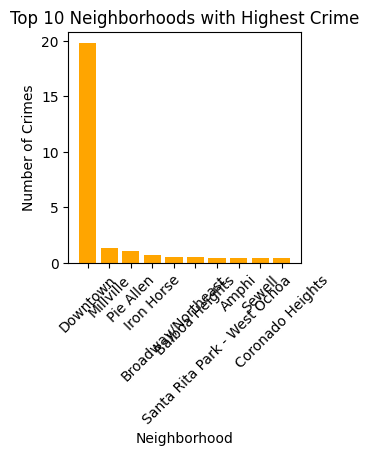

In [ ]:
# bar plot for 10 neighborhoods with highest crimes/person
neighborhoods_df = neighborhoods_df.sort_values(by='CRIME_RATE', ascending=False)
plt.bar(neighborhoods_df['NAME'].head(10), neighborhoods_df['CRIME_RATE'].head(10), color='orange')

plt.xlabel('Neighborhood')
plt.ylabel('Number of Crimes')
plt.title('Top 10 Neighborhoods with Highest Crime')

plt.rcParams['figure.figsize'] = [5, 9]
plt.xticks(rotation=45)

plt.show()

From the bar plot, we can see that downtown has a high crime rate. Based on this observation, we will add data about each incident's distance from the city center.

# Investigate relationship between crime rate and distance from downtown

In [ ]:

# constant values for coordinates of city center
downtown_lat = 32.2226
downtown_long = -110.9747
downtown_coords = (downtown_lat, downtown_long)

# calculate distance from downtown in miles
def calculate_distance(row):
    lat = row['LAT']
    long = row['LONG']
    if pd.isna(lat) or pd.isna(long) or lat == 0 or long == 0:
        return np.nan
    return geodesic((lat, long), downtown_coords).miles

# add distance column to the cleaned crime dataframe
df = df.copy()
df['distance_from_dt'] = df.apply(calculate_distance, axis=1)

df = df.dropna(subset=['distance_from_dt'])

df.head()


,INCI_ID,OFFENSE,WARD,NHA_NAME,LAT,LONG,Crime,CrimeType,CrimeCategory,distance_from_dt
0,1902138571,1104.0,3.0,Flowing Wells,32.272028,-110.990335,Part 2,Fraud,Property,3.526698
1,1903058566,1105.0,1.0,Midvale Park,32.131750,-111.009001,Part 2,Fraud,Property,6.574758
2,1905308540,1104.0,3.0,Dodge Flower,32.254180,-110.918274,Part 2,Fraud,Property,3.956566
3,1904298515,1105.0,3.0,Coronado Heights,32.263264,-110.976268,Part 2,Fraud,Property,2.803428
4,1905268517,1104.0,3.0,Campus Farm,32.272232,-110.948053,Part 2,Fraud,Property,3.759063


Create visualization of crimes and distance from city center.

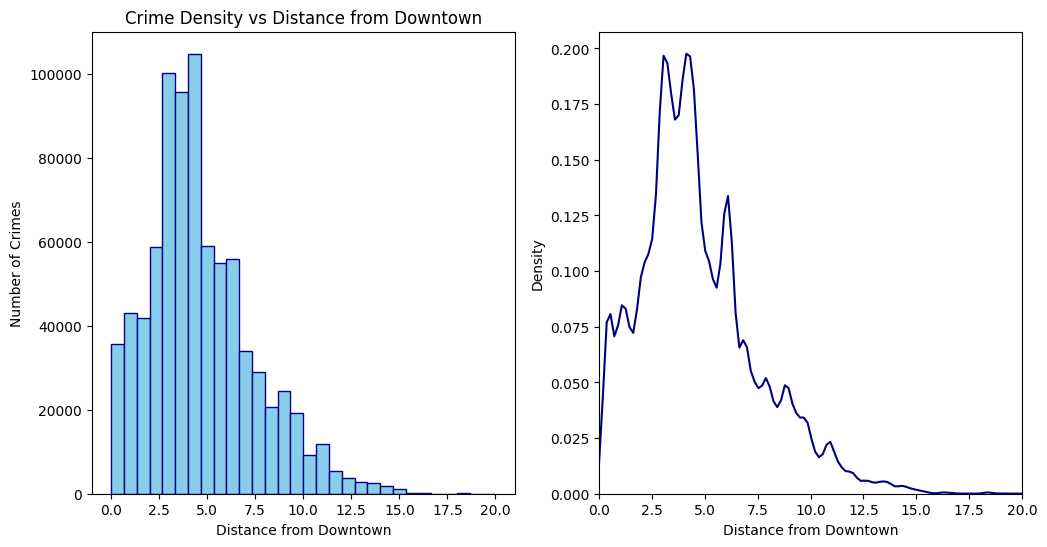

In [ ]:
# create two side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# histogram
axs[0].hist(df['distance_from_dt'], bins=30, color='skyblue', edgecolor='navy', range=(0, 20))
axs[0].set_xlabel('Distance from Downtown')
axs[0].set_ylabel('Number of Crimes')
axs[0].set_title('Crime Density vs Distance from Downtown')

# density curve sns
sns.kdeplot(data=df, x='distance_from_dt', ax=axs[1], color='navy')
axs[1].set_xlim(0, 20)
axs[1].set_xlabel('Distance from Downtown')
axs[1].set_ylabel('Density')

plt.show()

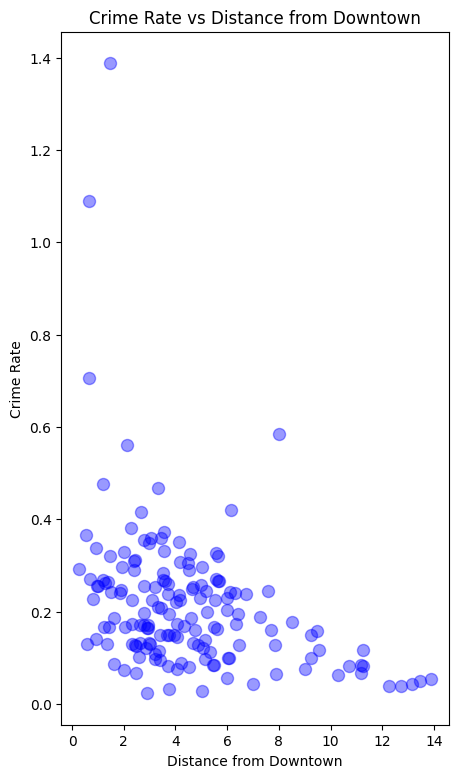

In [ ]:
# function to get avg dist from downtown for a neighborhood
def get_avg_dist(row):
    avg_dist = df[(df['NHA_NAME'] == row['NAME'])]['distance_from_dt'].mean()
    return avg_dist

# add a column to neighborhoods df for avg dist from downtown
neighborhoods_df = neighborhoods_df.copy()
neighborhoods_df['AVG_DIST'] = neighborhoods_df.apply(get_avg_dist, axis=1)

# drop downtown outlier
dist_df = neighborhoods_df[neighborhoods_df['NAME'] != 'Downtown']

# Create a scatterplot of crime rate vs distance from city center
plt.scatter(dist_df['AVG_DIST'], dist_df['CRIME_RATE'], color='blue', alpha=0.4, s=75)
plt.rcParams['figure.figsize'] = [5, 10]
plt.ylabel('Crime Rate')
plt.xlabel('Distance from Downtown')
plt.title('Crime Rate vs Distance from Downtown')
plt.show()


Map of crimes with latitude and longitude

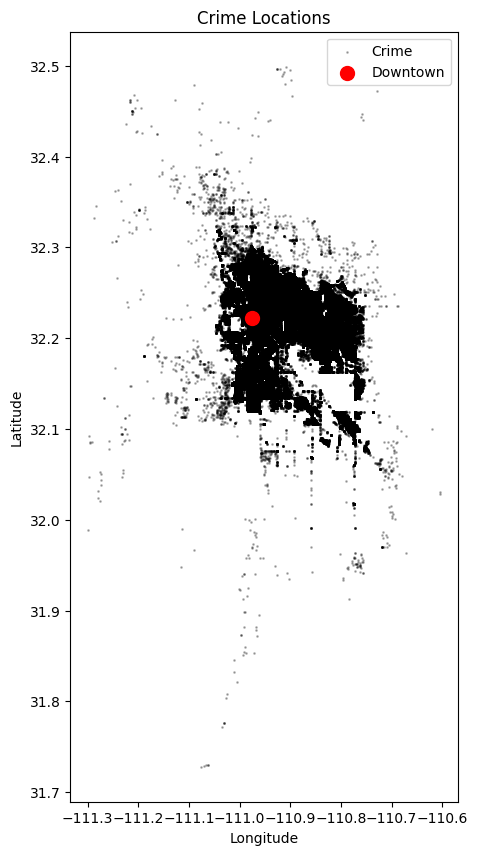

In [ ]:

# plot crimes with latitude on x-axis, longitude on y-axis
plt.scatter(df['LONG'], df['LAT'], color='black', alpha=0.25, s=1)
plt.rcParams['figure.figsize'] = [12,12]
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Crime Locations')

# add point for downtown
plt.scatter(downtown_long, downtown_lat, color='red', s=100)

# add key
plt.legend(['Crime', 'Downtown'])

plt.show()

Now, we will add the relevant data about each neighborhood into our large crime dataframe containing all the incidents.

In [ ]:
# add column to df for neighborhood income
df = df.copy()
df['INCOME'] = df['NHA_NAME'].map(neighborhoods_df.set_index('NAME')['INCOME'])

# add column for education ratio
df = df.copy()
df['EDU_RATIO'] = df['NHA_NAME'].map(neighborhoods_df.set_index('NAME')['EDU_RATIO'])

# add column for unemployment
df = df.copy()
df['UNEMPL'] = df['NHA_NAME'].map(neighborhoods_df.set_index('NAME')['UNEMPL'])

# rename avg distance
df = df.rename(columns={'distance_from_dt': 'AVG_DIST'})



# Explore changes over time

We will look at how crime rates have changed over the years for which we have data in each neighborhood and look for patterns using time series graphs.

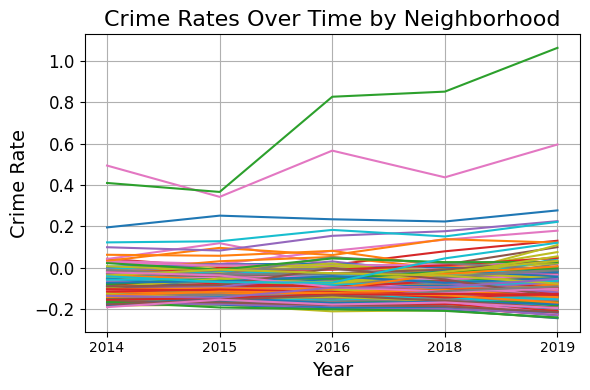

In [ ]:

plt.figure(figsize=(6, 4))
normalized_crime_rate_df = crime_rate_df.copy()

# drop na values in columns 1 thru 6
normalized_crime_rate_df = normalized_crime_rate_df.dropna(subset=normalized_crime_rate_df.columns[1:6])

# normalize data with z-score
for col in normalized_crime_rate_df.columns[1:6]:
    year_mean = normalized_crime_rate_df[col].mean()
    year_std = normalized_crime_rate_df[col].std()
    normalized_crime_rate_df[col] = (normalized_crime_rate_df[col] - year_mean) / year_std

# plot data, dropping outlier
for n_name in normalized_crime_rate_df['NAME']:
    if n_name != "Downtown":
      cr_data = normalized_crime_rate_df[normalized_crime_rate_df['NAME'] == n_name]
      plt.plot(cr_data.columns[1:6], cr_data.iloc[0, 1:6], label=n_name)

# set plot details
plt.title('Crime Rates Over Time by Neighborhood', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Crime Rate', fontsize=14)
plt.grid(True)
plt.yticks(fontsize=12)

# show plot
plt.tight_layout()
plt.show()


We used normalized data to make the graph more readable, but it's still a little cluttered. So we will create a graph with a random subset of 10 neighborhoods to better visualize time series changes. Re-run to see with different subset.

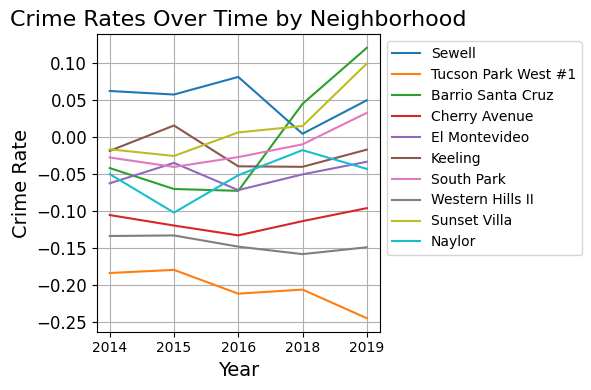

In [ ]:
# randomly select a subset of 10 neighborhoods
n_sample = normalized_crime_rate_df.sample(n=10)

# plot data
plt.figure(figsize=(6, 4))
for n_name in n_sample['NAME']:
    if n_name != "Downtown":
      cr_data = normalized_crime_rate_df[normalized_crime_rate_df['NAME'] == n_name]
      plt.plot(cr_data.columns[1:6], cr_data.iloc[0, 1:6], label=n_name)

# set plot details
plt.title('Crime Rates Over Time by Neighborhood', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Crime Rate', fontsize=14)
plt.grid(True)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# show plot
plt.tight_layout()
plt.show()


Plotting this data with different subsets does not show a distinct increase or decrease in crime rates from 2014 to 2019. We see a general decrease in crime rates from 2018 to 2019.

# Partitioning the data

Split into training and test sets, using a 70-30 split.

In [ ]:
np.random.seed(99)
train_size = int(0.7 * len(neighborhoods_df))

# randomly select training and test data indicies
train_indices = np.random.choice(neighborhoods_df.index, size=train_size, replace=False)
test_indices = np.setdiff1d(neighborhoods_df.index, train_indices)

# create training and test dataframes
train_df = neighborhoods_df.loc[train_indices]
test_df = neighborhoods_df.loc[test_indices]


In [ ]:
# partition df
np.random.seed(9)
train_size = int(0.7 * len(df))

# randomly select training and test data indicies
train_indices = np.random.choice(df.index, size=train_size, replace=False)
test_indices = np.setdiff1d(df.index, train_indices)

# create training and test dataframes
train_crime_df = df.loc[train_indices]
test_crime_df = df.loc[test_indices]

# Scatterplots for each feature





In order to get an idea of how each feature we identified is correlated to crime rate (if at all), we will use scatterplots for each individual feature against crime rate.

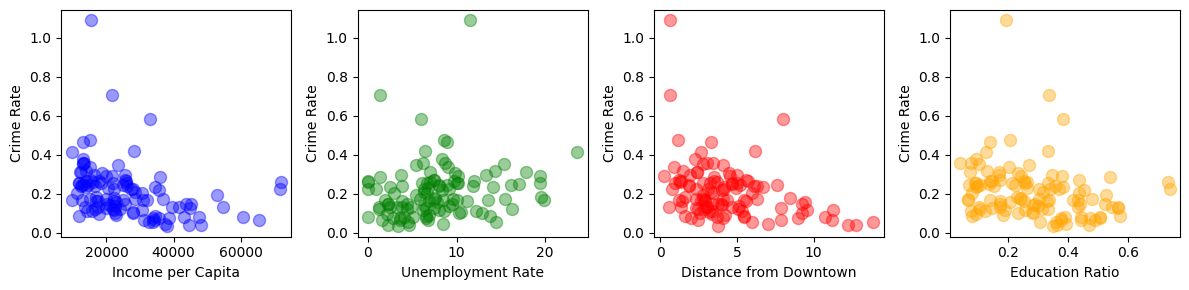

In [ ]:
# 4 scatterplots for crime rate vs features
plt.figure(figsize=(12, 3))

# first plot crime vs income
plt.subplot(1, 4, 1)
plt.scatter(train_df['INCOME'], train_df['CRIME_RATE'], color='blue', alpha=0.4, s=75)
plt.xlabel('Income per Capita')
plt.ylabel('Crime Rate')

# crime vs unemployment
plt.subplot(1, 4, 2)
plt.scatter(train_df['UNEMPL'], train_df['CRIME_RATE'], color='green', alpha=0.4, s=75)
plt.xlabel('Unemployment Rate')
plt.ylabel('Crime Rate')

# crime vs distance from downtown
plt.subplot(1, 4, 3)
plt.scatter(train_df['AVG_DIST'], train_df['CRIME_RATE'], color='red', alpha=0.4, s=75)
plt.xlabel('Distance from Downtown')
plt.ylabel('Crime Rate')

# crime vs education
plt.subplot(1, 4, 4)
plt.scatter(train_df['EDU_RATIO'], train_df['CRIME_RATE'], color='orange', alpha=0.4, s=75)
plt.xlabel('Education Ratio')
plt.ylabel('Crime Rate')

plt.tight_layout()
plt.show()

Based on these scatterplots, it is clear that neighborhoods with crime rates > 0.5 are outliers.

In [ ]:
# drop rows with crime rate > 0.5
train_df = train_df[train_df['CRIME_RATE'] < 0.5]
test_df = test_df[test_df['CRIME_RATE'] < 0.5]

# Training Linear and Polynomial Models

First, we will train a linear regression model with independent variable income per capita and dependent variable crime rate.

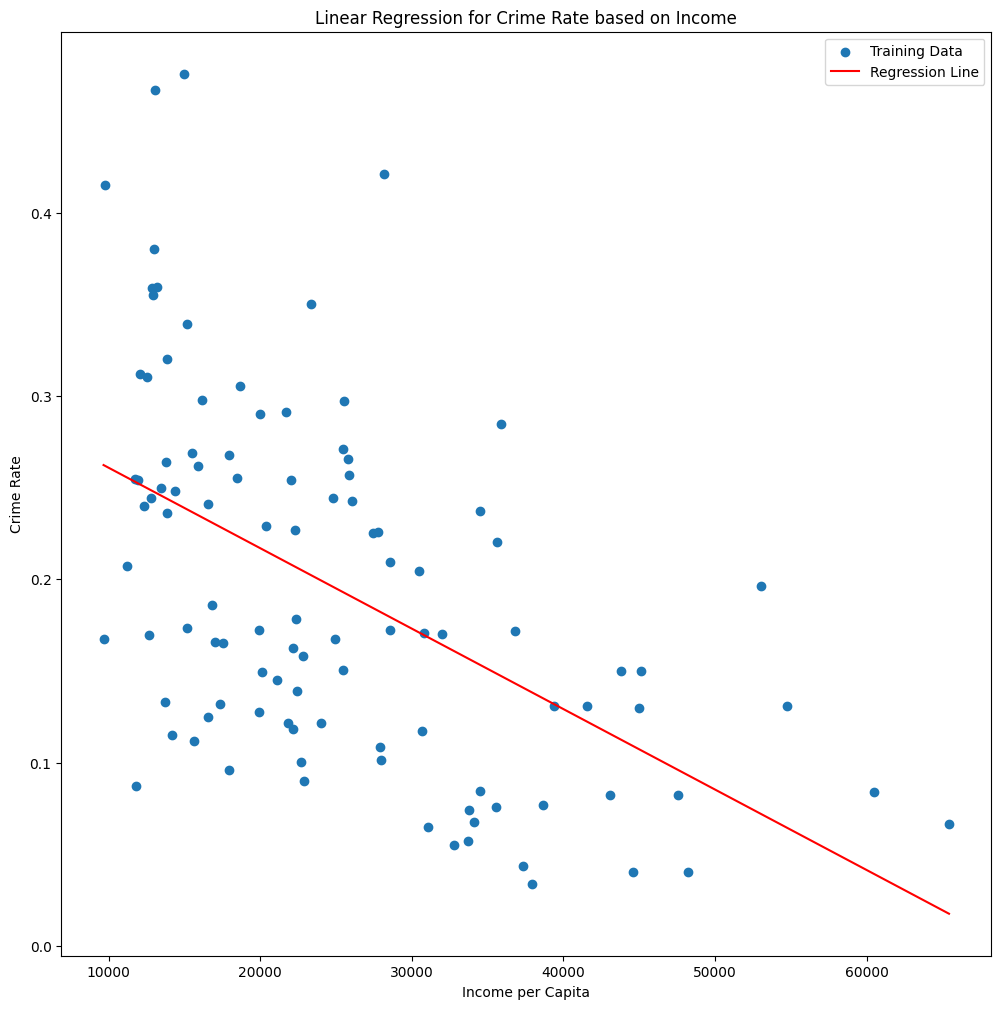

R-squared score is 0.27745127051144014


In [ ]:
# shuffle dataset
train_shuffled = train_df.sample(frac=1, random_state=9).reset_index(drop=True)

# drop outliers that are noise
train_shuffled = train_shuffled[train_shuffled['INCOME'] > 0]
train_shuffled = train_shuffled[train_shuffled['INCOME'] < 70000]

# create training data
Y_train = train_shuffled.copy()
Y_train = Y_train['CRIME_RATE'].values.reshape(-1,1)
X_train = train_shuffled.copy()
X_train = X_train['INCOME'].values.reshape(-1,1)

# train linear regression model
lr = linear_model.LinearRegression()
lr.fit(X_train, Y_train)

# compute R-squared score
score = lr.score(X_train, Y_train)

# plot data
plt.scatter(X_train, Y_train, label='Training Data')
x_dense = np.arange(X_train.min(), X_train.max(), 0.01).reshape(-1, 1)
y_dense = lr.predict(x_dense)
plt.plot(x_dense, y_dense, color='red', label='Regression Line')
plt.xlabel('Income per Capita')
plt.ylabel('Crime Rate')
plt.title('Linear Regression for Crime Rate based on Income')
plt.legend()
plt.show()

# Report score
print("R-squared score is", score)


We will try using a non-linear model next, by using x^2 data.

In [ ]:
train_shuffled['INCOME2'] = train_shuffled['INCOME'] ** 2
X_train_2 = train_shuffled[['INCOME', 'INCOME2']]
Y_train = train_shuffled['CRIME_RATE']

lr_2 = linear_model.LinearRegression()
lr_2.fit(X_train_2, Y_train)

score_2 = lr_2.score(X_train_2, Y_train)

print("R-squared score is", score_2)


R-squared score is 0.29808482455774277


This improved the R-squared score, which tells us that a linear model wasn't the best for this data. Now, we will try using multiple features.




In [ ]:
def findsubsets(S,k):
    return set(itertools.combinations(S, k))

In [ ]:
features = ['INCOME', 'UNEMPL', 'AVG_DIST', 'EDU_RATIO']

# find the best subset
best_score = None
best_features_lin = None

for k in range(1, len(features) + 1):
    for subset in findsubsets(features, k):
        X_train = train_shuffled[list(subset)].values
        Y_train = train_shuffled['CRIME_RATE'].values

        lr = linear_model.LinearRegression()
        lr.fit(X_train, Y_train)

        score = lr.score(X_train, Y_train)

        if best_score is None or score > best_score:
            best_score = score
            best_features_lin = list(subset)

print("Best R-squared score is", best_score, "with features", best_features_lin)

Best R-squared score is 0.3571293662996614 with features ['INCOME', 'UNEMPL', 'AVG_DIST', 'EDU_RATIO']


Now, we will do the same with polynomial regression.

In [ ]:
train_shuffled['INCOME2'] = train_shuffled['INCOME'] ** 2
train_shuffled['UNEMPL2'] = train_shuffled['UNEMPL'] ** 2
train_shuffled['AVG_DIST2'] = train_shuffled['AVG_DIST'] ** 2
train_shuffled['EDU_RATIO2'] = train_shuffled['EDU_RATIO'] ** 2

features = ['INCOME', 'INCOME2', 'UNEMPL', 'UNEMPL2', 'AVG_DIST', 'AVG_DIST2', 'EDU_RATIO', 'EDU_RATIO2']
X_train_2 = train_shuffled[features]
Y_train = train_shuffled['CRIME_RATE']

# find the best subset
best_score = None
best_features_poly = None

for k in range(1, len(features) + 1):
    for subset in findsubsets(features, k):
        X_train = train_shuffled[list(subset)].values
        Y_train = train_shuffled['CRIME_RATE'].values

        lr = linear_model.LinearRegression()
        lr.fit(X_train, Y_train)

        score = lr.score(X_train, Y_train)

        if best_score is None or score > best_score:
            best_score = score
            best_features_poly = list(subset)


print("best R-squared score is", best_score, "with features", best_features_poly)


best R-squared score is 0.4001753921606217 with features ['INCOME', 'INCOME2', 'UNEMPL', 'UNEMPL2', 'AVG_DIST', 'AVG_DIST2', 'EDU_RATIO', 'EDU_RATIO2']


Since the r-squared scores were all fairly low for the models above, we will use regularization to try to avoid overfitting.

# Ridge


Train a Ridge Regression model for the data.

In [ ]:
# use best feature subset from linear regression
X_train = train_shuffled[best_features_lin]
Y_train = train_shuffled['CRIME_RATE']

# Generate alpha values
alpha_vals = np.logspace(-1, 3, 50)

# Track best score and corresponding alpha
best_score = None
best_alpha_ridge = None

avg_scores = []
stds = []

# Perform 20-fold cv of Ridge regression model
for alpha in alpha_vals:
  model = linear_model.Ridge(alpha=alpha)
  scores = cross_val_score(model, X_train, Y_train, cv=20, scoring='r2')

  # add mean score and std to list
  avg_score = scores.mean()
  avg_scores.append(avg_score)
  std = scores.std()
  stds.append(std)

  # update best score and alpha
  if best_score is None or scores.max() > best_score:
    best_score = scores.max()
    best_alpha_ridge = alpha

# Print results
print("Best R2 score is", best_score, "with alpha =", best_alpha_ridge)

Best R2 score is 0.7122735384981769 with alpha = 6.25055192527397


# Lasso

Train a Lasso Regression model for the data.

In [ ]:
# Perform 20-fold cv for Lasso
model = linear_model.LassoLarsCV(cv=20)
model.fit(X_train, Y_train)

# Get MSE and alpha lists
mse_path = model.mse_path_
alphas = model.cv_alphas_

# Compute mean and standard error
mean_mse = mse_path.mean(axis=1)

# Report best alpha value and corresponding average MSE
best_alpha_lasso = model.alpha_
best_mse = mean_mse[alphas.tolist().index(best_alpha_lasso)]
print("Best alpha value is", best_alpha_lasso, "with mean MSE =", best_mse)

Best alpha value is 0.014816776616862582 with mean MSE = 0.006634085812013327


# Evaluate models


Evaluate the linear regression model that seemed to be the best fit on the training data.

In [ ]:
# shuffle test data
test_shuffled = test_df.sample(frac=1, random_state=9).reset_index(drop=True)

test_shuffled = test_shuffled[test_shuffled['INCOME'] > 0]
test_shuffled = test_shuffled[test_shuffled['INCOME'] < 70000]

# evaluate best linear regression model
X_test = test_shuffled[best_features_lin].values
Y_test = test_shuffled['CRIME_RATE'].values

X_train = train_shuffled[best_features_lin].values
Y_train = train_shuffled['CRIME_RATE'].values

# train model
lr = linear_model.LinearRegression()
lr.fit(X_train, Y_train)

# predictions on test data
Y_pred = lr.predict(X_test)

# calculate MSE
mse = mean_squared_error(Y_test, Y_pred)

# calculate R-squared
r2 = lr.score(X_test, Y_test)

# report MSE and R-squared
print("Mean Squared Error:", mse)
print("R-squared =", r2)


Mean Squared Error: 0.007512050382776119
R-squared = 0.22710125773218537


Evaluate the best polynomial regression model.

In [ ]:
# add squares of feature values to test data
test_shuffled['INCOME2'] = test_shuffled['INCOME'] ** 2
test_shuffled['UNEMPL2'] = test_shuffled['UNEMPL'] ** 2
test_shuffled['AVG_DIST2'] = test_shuffled['AVG_DIST'] ** 2
test_shuffled['EDU_RATIO2'] = test_shuffled['EDU_RATIO'] ** 2

# evaluate best polynomial regression model
X_test = test_shuffled[best_features_poly].values
Y_test = test_shuffled['CRIME_RATE'].values

X_train = train_shuffled[best_features_poly].values
Y_train = train_shuffled['CRIME_RATE'].values

# train model
lr = linear_model.LinearRegression()
lr.fit(X_train, Y_train)

# predictions on test data
Y_pred = lr.predict(X_test)

# calculate MSE
mse = mean_squared_error(Y_test, Y_pred)

# calculate R-squared
r2 = lr.score(X_test, Y_test)

# report MSE and R-squared
print("Mean Squared Error:", mse)
print("R-squared =", r2)


Mean Squared Error: 0.00756187610665801
R-squared = 0.22197479593299474


It is interesting to not here that the linear and polynomial regression models had very similar results when being evaluated on the test data.

Next, we will evaluate our Ridge Regression models, using the best alpha.

In [ ]:
# evaluate ridge model
X_test = test_shuffled[best_features_lin].values
Y_test = test_shuffled['CRIME_RATE'].values

X_train = train_shuffled[best_features_lin].values
Y_train = train_shuffled['CRIME_RATE'].values

# train model
ridge = linear_model.Ridge(alpha=best_alpha_ridge)
ridge.fit(X_train, Y_train)

# predictions on test data
Y_pred = ridge.predict(X_test)

# calculate MSE
mse = mean_squared_error(Y_test, Y_pred)

# calculate R-squared
r2 = ridge.score(X_test, Y_test)

# report MSE and R-squared
print("Mean Squared Error:", mse)
print("R-squared =", r2)


Mean Squared Error: 0.007914246583522681
R-squared = 0.18572015379088935


As a visualization, we will graph the residuals of the Ridge Regression model using a histogram. We will see that it appears to be a normal distribution.

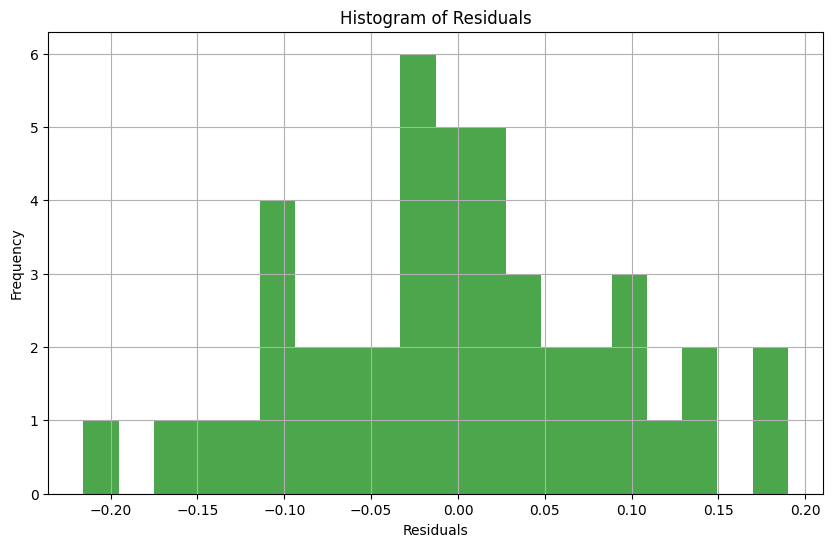

In [ ]:
# histogram of residuals for ridge regression model
plt.figure(figsize=(10, 6))
residuals = Y_test - Y_pred

plt.hist(residuals, bins=20, color='green', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.grid(True)
plt.show()

Finally, we will evaluate the Lasso Regression model.

In [ ]:
# evaluate lasso model
X_test = test_shuffled[best_features_lin].values
Y_test = test_shuffled['CRIME_RATE'].values

X_train = train_shuffled[best_features_lin].values
Y_train = train_shuffled['CRIME_RATE'].values

# train model
lasso = linear_model.Lasso(alpha=best_alpha_lasso)
lasso.fit(X_train, Y_train)

# predictions on test data
Y_pred = lasso.predict(X_test)

# calculate MSE
mse = mean_squared_error(Y_test, Y_pred)

# calculate R-squared
r2 = lasso.score(X_test, Y_test)

# report MSE and R-squared
print("Mean Squared Error:", mse)
print("R-squared =", r2)


Mean Squared Error: 0.00795779566869499
R-squared = 0.18123948187822936
